In [1]:
from models.fusion_network import get_fusion_net
from tensorflow.keras.utils import plot_model
from keras.callbacks import TensorBoard
import os
from DataLoader import Data_loader


### Load and visualize example data

In [2]:
dataset_path = "C:\\Users\\mar-z\\progetti\\data\\3dRenderingLight\\simple_geometry\\global_dataset\\images"
gt_path = os.path.join(dataset_path, "light_angle.csv")
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")

batch_size = 4

model_output_names = ['L', 'L_img']
img_size = (144,256)
train_loader = Data_loader(batch_size, train_dir, gt_path, img_size = img_size, model_output_names=model_output_names)
val_loader = Data_loader(batch_size, val_dir, gt_path, img_size = img_size, model_output_names=model_output_names)

# train_loader.visualize_batch(img_size = img_size)
# val_loader.visualize_batch()

n. imgs: 13239
n. imgs: 1892


### build model and callbacks

In [14]:
from keras.callbacks import ModelCheckpoint
from models.fusion_network import FusionNetWrap


model_path = "../models_phong_plus_fine_tuning_VIDIT"
# model_path = "../models_phong_plus_fine_tuning_synthetic"


# pretrained_weights = None
# pretrained_weights = "../models_phong_plus_fine_tuning_synthetic/best/model_050-0.054.hdf5"
# pretrained_weights = "../models_phong_plus_VIDIT_FT/best/model_046-0.048.hdf5"
# pretrained_weights = "../models_phong_plus/best/model_157-0.049.hdf5"
# pretrained_weights = "../models_phong_plus_SID2_FT/best/model_048-0.134.hdf5"
pretrained_weights = "../models_phong_plus_SID2_FT/model_010-0.213.hdf5"

model_wrap = FusionNetWrap(pretrained_weights_file = pretrained_weights)
model = model_wrap.get_fusion_net()

model_file_name = os.path.join(model_path, 'model_{epoch:03d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(model_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


Model: "fusion_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_input (InputLayer)         [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_202 (ZeroPaddin  (None, 150, 262, 3)  0          ['RGB_input[0][0]']              
 g2D)                                                                                             
                                                                                                  
 conv2d_474 (Conv2D)            (None, 144, 256, 12  18944       ['zero_padding2d_202[0][0]']     
                                8)                                                       

### freeze all weights apart from Dense layers (light network)

In [15]:

# # unfreeze dense layers' weights of light network
# light_net = model_wrap.get_light_net()

# for layer in light_net.layers:
#     if "dense" in layer.name:
#         layer.trainable = True
#     else:
#         layer.trainable = False
        
# # freeze all layers of normal net
# normal_net = model_wrap.get_normal_net()
# for layer in normal_net.layers:
#     layer.trainable = False


# compile model
losses = {model_output_names[0]: 'mean_absolute_error', model_output_names[1]: 'mean_squared_error'}

# define weight for each loss
lossWeights = {model_output_names[0]: 1.0, model_output_names[1]: 1.0}

model.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=["accuracy"])

model.summary()


Model: "fusion_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_input (InputLayer)         [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_202 (ZeroPaddin  (None, 150, 262, 3)  0          ['RGB_input[0][0]']              
 g2D)                                                                                             
                                                                                                  
 conv2d_474 (Conv2D)            (None, 144, 256, 12  18944       ['zero_padding2d_202[0][0]']     
                                8)                                                       

### train model

In [5]:
N_epochs = 20
portion = 1

history = model.fit(
        train_loader,
        steps_per_epoch= int(portion * (train_loader.N_samples() // batch_size)),
        epochs=N_epochs,
        validation_data=val_loader,
        validation_steps=int(portion * (val_loader.N_samples() // batch_size)),
        callbacks = [checkpoint]
        )


# save model architecture
model_json = model.to_json()
with open(os.path.join(model_path, "model.json"), "w") as json_file:
    json_file.write(model_json)
    
    
# model.save(os.path.join(model_path, "model_after_training"))


# with open('train_output.txt', 'w') as f:
#     f.write(cap.stdout)

Epoch 1/20
2100/2100 [==============================] - ETA: 0s - loss: 0.3016 - L_loss: 0.2968 - L_img_loss: 0.0047 - L_accuracy: 0.8726 - L_img_accuracy: 0.4071
Epoch 00001: val_loss improved from inf to 0.28828, saving model to ../models_phong_plus_fine_tuning_VIDIT\model_001-0.288.hdf5
2100/2100 [==============================] - 680s 318ms/step - loss: 0.3016 - L_loss: 0.2968 - L_img_loss: 0.0047 - L_accuracy: 0.8726 - L_img_accuracy: 0.4071 - val_loss: 0.2883 - val_L_loss: 0.2844 - val_L_img_loss: 0.0038 - val_L_accuracy: 0.8608 - val_L_img_accuracy: 0.4194
Epoch 2/20
2100/2100 [==============================] - ETA: 0s - loss: 0.2879 - L_loss: 0.2834 - L_img_loss: 0.0045 - L_accuracy: 0.8745 - L_img_accuracy: 0.4081
Epoch 00002: val_loss improved from 0.28828 to 0.27926, saving model to ../models_phong_plus_fine_tuning_VIDIT\model_002-0.279.hdf5
2100/2100 [==============================] - 839s 399ms/step - loss: 0.2879 - L_loss: 0.2834 - L_img_loss: 0.0045 - L_accuracy: 0.8745 

Epoch 16/20
2100/2100 [==============================] - ETA: 0s - loss: 0.2705 - L_loss: 0.2659 - L_img_loss: 0.0046 - L_accuracy: 0.8704 - L_img_accuracy: 0.4028
Epoch 00016: val_loss did not improve from 0.26106
2100/2100 [==============================] - 839s 400ms/step - loss: 0.2705 - L_loss: 0.2659 - L_img_loss: 0.0046 - L_accuracy: 0.8704 - L_img_accuracy: 0.4028 - val_loss: 0.2620 - val_L_loss: 0.2580 - val_L_img_loss: 0.0040 - val_L_accuracy: 0.8608 - val_L_img_accuracy: 0.4162
Epoch 17/20
2100/2100 [==============================] - ETA: 0s - loss: 0.2698 - L_loss: 0.2652 - L_img_loss: 0.0046 - L_accuracy: 0.8717 - L_img_accuracy: 0.4028
Epoch 00017: val_loss did not improve from 0.26106
2100/2100 [==============================] - 840s 400ms/step - loss: 0.2698 - L_loss: 0.2652 - L_img_loss: 0.0046 - L_accuracy: 0.8717 - L_img_accuracy: 0.4028 - val_loss: 0.2635 - val_L_loss: 0.2596 - val_L_img_loss: 0.0040 - val_L_accuracy: 0.8608 - val_L_img_accuracy: 0.4166
Epoch 18/20


### resume training: unfreeze all weights and small lr.

In [6]:

for layer in model.layers:
    layer.trainable = True
model.summary()



Model: "fusion_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_input (InputLayer)         [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_66 (ZeroPadding  (None, 150, 262, 3)  0          ['RGB_input[0][0]']              
 2D)                                                                                              
                                                                                                  
 conv2d_154 (Conv2D)            (None, 144, 256, 12  18944       ['zero_padding2d_66[0][0]']      
                                8)                                                       

In [10]:
from tensorflow.keras.optimizers import SGD

lr = 1.e-4
sgd = SGD(learning_rate=lr)

model.compile(loss=losses, loss_weights=lossWeights, optimizer=sgd, metrics=["accuracy"])

model.summary()


Model: "fusion_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_input (InputLayer)         [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_66 (ZeroPadding  (None, 150, 262, 3)  0          ['RGB_input[0][0]']              
 2D)                                                                                              
                                                                                                  
 conv2d_154 (Conv2D)            (None, 144, 256, 12  18944       ['zero_padding2d_66[0][0]']      
                                8)                                                       

In [11]:
from keras.callbacks import ModelCheckpoint

model_file_name = os.path.join(model_path, 'model_{epoch:03d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(model_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

N_epochs = 50
portion = 1

history = model.fit(
        train_loader,
        steps_per_epoch= int(portion * (train_loader.N_samples() // batch_size)),
        epochs=N_epochs,
        validation_data=val_loader,
        validation_steps=int(portion * (val_loader.N_samples() // batch_size)),
        callbacks = [checkpoint])

Epoch 1/50
2100/2100 [==============================] - ETA: 0s - loss: 0.3001 - L_loss: 0.2828 - L_img_loss: 0.0173 - L_accuracy: 0.8712 - L_img_accuracy: 0.2992
Epoch 00001: val_loss improved from inf to 0.29011, saving model to ../models_phong_plus_fine_tuning_VIDIT\model_001-0.290.hdf5
2100/2100 [==============================] - 2850s 1s/step - loss: 0.3001 - L_loss: 0.2828 - L_img_loss: 0.0173 - L_accuracy: 0.8712 - L_img_accuracy: 0.2992 - val_loss: 0.2901 - val_L_loss: 0.2809 - val_L_img_loss: 0.0092 - val_L_accuracy: 0.8608 - val_L_img_accuracy: 0.3196
Epoch 2/50
2100/2100 [==============================] - ETA: 0s - loss: 0.2928 - L_loss: 0.2809 - L_img_loss: 0.0119 - L_accuracy: 0.8701 - L_img_accuracy: 0.3077
Epoch 00002: val_loss improved from 0.29011 to 0.28725, saving model to ../models_phong_plus_fine_tuning_VIDIT\model_002-0.287.hdf5
2100/2100 [==============================] - 2821s 1s/step - loss: 0.2928 - L_loss: 0.2809 - L_img_loss: 0.0119 - L_accuracy: 0.8701 - L_

Epoch 16/50
2100/2100 [==============================] - ETA: 0s - loss: 0.2818 - L_loss: 0.2735 - L_img_loss: 0.0083 - L_accuracy: 0.8731 - L_img_accuracy: 0.3500
Epoch 00016: val_loss did not improve from 0.27632
2100/2100 [==============================] - 2833s 1s/step - loss: 0.2818 - L_loss: 0.2735 - L_img_loss: 0.0083 - L_accuracy: 0.8731 - L_img_accuracy: 0.3500 - val_loss: 0.2783 - val_L_loss: 0.2734 - val_L_img_loss: 0.0049 - val_L_accuracy: 0.8608 - val_L_img_accuracy: 0.3713
Epoch 17/50
2100/2100 [==============================] - ETA: 0s - loss: 0.2823 - L_loss: 0.2741 - L_img_loss: 0.0082 - L_accuracy: 0.8717 - L_img_accuracy: 0.3507
Epoch 00017: val_loss did not improve from 0.27632
2100/2100 [==============================] - 2833s 1s/step - loss: 0.2823 - L_loss: 0.2741 - L_img_loss: 0.0082 - L_accuracy: 0.8717 - L_img_accuracy: 0.3507 - val_loss: 0.2763 - val_L_loss: 0.2712 - val_L_img_loss: 0.0052 - val_L_accuracy: 0.8608 - val_L_img_accuracy: 0.3683
Epoch 18/50
2100

Epoch 32/50
2002/2100 [===========================>..] - ETA: 2:08 - loss: 0.2801 - L_loss: 0.2725 - L_img_loss: 0.0076 - L_accuracy: 0.8725 - L_img_accuracy: 0.3585

KeyboardInterrupt: 

## prediction on test set

In [16]:
import math
import re
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2

def read_gt_light(light_gt_path):

    gt_light = {}
    with open(light_gt_path) as f:
        lines = f.readlines()

    for line in lines[2:]:
        tokens = line.split(";")
        name = tokens[0]
        theta = float(tokens[1])
        phi = float(tokens[2])
        Ly = math.sin(phi)
        Lx = math.cos(phi) * math.cos(theta)
        Lz = math.cos(phi) * math.sin(theta)
        
        gt_light[name] = [Lx,Ly,Lz]

    return gt_light



# preprocess input image for network
# img: PIL image
def preprocess_input(img, img_size=None):

    pil_img = Image.fromarray(img)

    if img_size != None:
        pil_img = pil_img.resize(img_size[::-1]) # resize method need size as (Width, Height)

    x = np.array(pil_img, dtype = np.float32)
    
    # ignore alpha channel
    if(x.shape[-1] == 4):
        x = x[...,:-1]
    generator_preprocess = ImageDataGenerator(rescale=1./255)
    x = generator_preprocess.standardize(x)
    return x


def evaluate(model, data_dir, img_size, gt_light_path, save_path = None):

    # read groundtruth light angles
    gt_light = read_gt_light(gt_light_path)

    # dictionary img_name -> [gt_angle_rad, model_angle_rad]
    predictions = {}

    cont = 0

    pixel_factor = 50

    if save_path and not os.path.exists(save_path):
        os.makedirs(save_path)

    regex_img = r".*\.(png|jpg)$"
    list_imgs = [f for f in os.listdir(data_dir) if re.search(regex_img,f)]

    print("found {} images".format(len(list_imgs)))

    for i, img_name in enumerate(list_imgs):

        print("processing img {} of {}".format(i+1, len(list_imgs)))

        #read image
        img = np.array(Image.open(os.path.join(data_dir, img_name)))
        
        # preprocess
        x = preprocess_input(img, img_size = img_size)

        # predict
        out = model.predict(np.expand_dims(x, axis = 0))
        L_hat = out[0][0]
        
        # groundtruth
        L = gt_light[img_name]

        predictions[img_name] = [L, L_hat.tolist()] # per passsare da array di un elemento ad elemneto semplice

        if save_path:
            start = (int(img.shape[1] / 2), int(img.shape[0] / 2))
            end = (start[0] + int(pixel_factor * L[0]), start[1] - int(pixel_factor * L[1]))
            end_pred = (start[0] + int(pixel_factor * L_hat[0]), start[1] - int(pixel_factor * L_hat[1]))

            cv2.arrowedLine(img, start, end, (0, 255, 0), thickness = 2)
            cv2.arrowedLine(img, start, end_pred, (255, 255, 0), thickness = 2)

            Image.fromarray(img).save(os.path.join(save_path, img_name))
        
        cont+=1

    return predictions


In [17]:
# dataset_path = "C:/Users/mar-z/progetti/data/3dRenderingLight/simple_geometry/global_dataset/images"
# dataset_path = "C:/Users/mar-z/progetti/data/VIDIT"
# dataset_path = "C:\\Users\\mar-z\\progetti\\data\\3dRenderingLight\\simple_geometry\\global_dataset\\images"
# dataset_path = "C:\\Users\\mar-z\\progetti\\data\\outdoor_cpp"
dataset_path = "C:\\Users\\mar-z\\progetti\\data\\SID2"


# gt_path = os.path.join(dataset_path, "light_angle.csv")
gt_path = os.path.join(dataset_path, "light.csv")

test_dir = os.path.join(dataset_path, "test")

# save_path = "./test_predictions_phong_plus_fine_tuning_VIDIT"
# save_path = "./test_predictions_phong_plus_fine_tuning_synthetic"
# save_path = "./test_predictions_phong_plus_outdoor"
# save_path = "./test_predictions_phong_plus_fine_tuning_SID2"
# save_path = "./test_predictions_phong_plus_NO_FT"
save_path = "./test_predictions_phong_plus_FT10"

if not os.path.exists(save_path):
    os.makedirs(save_path)

predictions = evaluate(model, test_dir, img_size, gt_path, save_path=None)



found 19138 images
processing img 1 of 19138
processing img 2 of 19138
processing img 3 of 19138
processing img 4 of 19138
processing img 5 of 19138
processing img 6 of 19138
processing img 7 of 19138
processing img 8 of 19138
processing img 9 of 19138
processing img 10 of 19138
processing img 11 of 19138
processing img 12 of 19138
processing img 13 of 19138
processing img 14 of 19138
processing img 15 of 19138
processing img 16 of 19138
processing img 17 of 19138
processing img 18 of 19138
processing img 19 of 19138
processing img 20 of 19138
processing img 21 of 19138
processing img 22 of 19138
processing img 23 of 19138
processing img 24 of 19138
processing img 25 of 19138
processing img 26 of 19138
processing img 27 of 19138
processing img 28 of 19138
processing img 29 of 19138
processing img 30 of 19138
processing img 31 of 19138
processing img 32 of 19138
processing img 33 of 19138
processing img 34 of 19138
processing img 35 of 19138
processing img 36 of 19138
processing img 37 

processing img 298 of 19138
processing img 299 of 19138
processing img 300 of 19138
processing img 301 of 19138
processing img 302 of 19138
processing img 303 of 19138
processing img 304 of 19138
processing img 305 of 19138
processing img 306 of 19138
processing img 307 of 19138
processing img 308 of 19138
processing img 309 of 19138
processing img 310 of 19138
processing img 311 of 19138
processing img 312 of 19138
processing img 313 of 19138
processing img 314 of 19138
processing img 315 of 19138
processing img 316 of 19138
processing img 317 of 19138
processing img 318 of 19138
processing img 319 of 19138
processing img 320 of 19138
processing img 321 of 19138
processing img 322 of 19138
processing img 323 of 19138
processing img 324 of 19138
processing img 325 of 19138
processing img 326 of 19138
processing img 327 of 19138
processing img 328 of 19138
processing img 329 of 19138
processing img 330 of 19138
processing img 331 of 19138
processing img 332 of 19138
processing img 333 o

processing img 592 of 19138
processing img 593 of 19138
processing img 594 of 19138
processing img 595 of 19138
processing img 596 of 19138
processing img 597 of 19138
processing img 598 of 19138
processing img 599 of 19138
processing img 600 of 19138
processing img 601 of 19138
processing img 602 of 19138
processing img 603 of 19138
processing img 604 of 19138
processing img 605 of 19138
processing img 606 of 19138
processing img 607 of 19138
processing img 608 of 19138
processing img 609 of 19138
processing img 610 of 19138
processing img 611 of 19138
processing img 612 of 19138
processing img 613 of 19138
processing img 614 of 19138
processing img 615 of 19138
processing img 616 of 19138
processing img 617 of 19138
processing img 618 of 19138
processing img 619 of 19138
processing img 620 of 19138
processing img 621 of 19138
processing img 622 of 19138
processing img 623 of 19138
processing img 624 of 19138
processing img 625 of 19138
processing img 626 of 19138
processing img 627 o

processing img 886 of 19138
processing img 887 of 19138
processing img 888 of 19138
processing img 889 of 19138
processing img 890 of 19138
processing img 891 of 19138
processing img 892 of 19138
processing img 893 of 19138
processing img 894 of 19138
processing img 895 of 19138
processing img 896 of 19138
processing img 897 of 19138
processing img 898 of 19138
processing img 899 of 19138
processing img 900 of 19138
processing img 901 of 19138
processing img 902 of 19138
processing img 903 of 19138
processing img 904 of 19138
processing img 905 of 19138
processing img 906 of 19138
processing img 907 of 19138
processing img 908 of 19138
processing img 909 of 19138
processing img 910 of 19138
processing img 911 of 19138
processing img 912 of 19138
processing img 913 of 19138
processing img 914 of 19138
processing img 915 of 19138
processing img 916 of 19138
processing img 917 of 19138
processing img 918 of 19138
processing img 919 of 19138
processing img 920 of 19138
processing img 921 o

processing img 1175 of 19138
processing img 1176 of 19138
processing img 1177 of 19138
processing img 1178 of 19138
processing img 1179 of 19138
processing img 1180 of 19138
processing img 1181 of 19138
processing img 1182 of 19138
processing img 1183 of 19138
processing img 1184 of 19138
processing img 1185 of 19138
processing img 1186 of 19138
processing img 1187 of 19138
processing img 1188 of 19138
processing img 1189 of 19138
processing img 1190 of 19138
processing img 1191 of 19138
processing img 1192 of 19138
processing img 1193 of 19138
processing img 1194 of 19138
processing img 1195 of 19138
processing img 1196 of 19138
processing img 1197 of 19138
processing img 1198 of 19138
processing img 1199 of 19138
processing img 1200 of 19138
processing img 1201 of 19138
processing img 1202 of 19138
processing img 1203 of 19138
processing img 1204 of 19138
processing img 1205 of 19138
processing img 1206 of 19138
processing img 1207 of 19138
processing img 1208 of 19138
processing img

processing img 1460 of 19138
processing img 1461 of 19138
processing img 1462 of 19138
processing img 1463 of 19138
processing img 1464 of 19138
processing img 1465 of 19138
processing img 1466 of 19138
processing img 1467 of 19138
processing img 1468 of 19138
processing img 1469 of 19138
processing img 1470 of 19138
processing img 1471 of 19138
processing img 1472 of 19138
processing img 1473 of 19138
processing img 1474 of 19138
processing img 1475 of 19138
processing img 1476 of 19138
processing img 1477 of 19138
processing img 1478 of 19138
processing img 1479 of 19138
processing img 1480 of 19138
processing img 1481 of 19138
processing img 1482 of 19138
processing img 1483 of 19138
processing img 1484 of 19138
processing img 1485 of 19138
processing img 1486 of 19138
processing img 1487 of 19138
processing img 1488 of 19138
processing img 1489 of 19138
processing img 1490 of 19138
processing img 1491 of 19138
processing img 1492 of 19138
processing img 1493 of 19138
processing img

processing img 1745 of 19138
processing img 1746 of 19138
processing img 1747 of 19138
processing img 1748 of 19138
processing img 1749 of 19138
processing img 1750 of 19138
processing img 1751 of 19138
processing img 1752 of 19138
processing img 1753 of 19138
processing img 1754 of 19138
processing img 1755 of 19138
processing img 1756 of 19138
processing img 1757 of 19138
processing img 1758 of 19138
processing img 1759 of 19138
processing img 1760 of 19138
processing img 1761 of 19138
processing img 1762 of 19138
processing img 1763 of 19138
processing img 1764 of 19138
processing img 1765 of 19138
processing img 1766 of 19138
processing img 1767 of 19138
processing img 1768 of 19138
processing img 1769 of 19138
processing img 1770 of 19138
processing img 1771 of 19138
processing img 1772 of 19138
processing img 1773 of 19138
processing img 1774 of 19138
processing img 1775 of 19138
processing img 1776 of 19138
processing img 1777 of 19138
processing img 1778 of 19138
processing img

processing img 2029 of 19138
processing img 2030 of 19138
processing img 2031 of 19138
processing img 2032 of 19138
processing img 2033 of 19138
processing img 2034 of 19138
processing img 2035 of 19138
processing img 2036 of 19138
processing img 2037 of 19138
processing img 2038 of 19138
processing img 2039 of 19138
processing img 2040 of 19138
processing img 2041 of 19138
processing img 2042 of 19138
processing img 2043 of 19138
processing img 2044 of 19138
processing img 2045 of 19138
processing img 2046 of 19138
processing img 2047 of 19138
processing img 2048 of 19138
processing img 2049 of 19138
processing img 2050 of 19138
processing img 2051 of 19138
processing img 2052 of 19138
processing img 2053 of 19138
processing img 2054 of 19138
processing img 2055 of 19138
processing img 2056 of 19138
processing img 2057 of 19138
processing img 2058 of 19138
processing img 2059 of 19138
processing img 2060 of 19138
processing img 2061 of 19138
processing img 2062 of 19138
processing img

processing img 2314 of 19138
processing img 2315 of 19138
processing img 2316 of 19138
processing img 2317 of 19138
processing img 2318 of 19138
processing img 2319 of 19138
processing img 2320 of 19138
processing img 2321 of 19138
processing img 2322 of 19138
processing img 2323 of 19138
processing img 2324 of 19138
processing img 2325 of 19138
processing img 2326 of 19138
processing img 2327 of 19138
processing img 2328 of 19138
processing img 2329 of 19138
processing img 2330 of 19138
processing img 2331 of 19138
processing img 2332 of 19138
processing img 2333 of 19138
processing img 2334 of 19138
processing img 2335 of 19138
processing img 2336 of 19138
processing img 2337 of 19138
processing img 2338 of 19138
processing img 2339 of 19138
processing img 2340 of 19138
processing img 2341 of 19138
processing img 2342 of 19138
processing img 2343 of 19138
processing img 2344 of 19138
processing img 2345 of 19138
processing img 2346 of 19138
processing img 2347 of 19138
processing img

processing img 2599 of 19138
processing img 2600 of 19138
processing img 2601 of 19138
processing img 2602 of 19138
processing img 2603 of 19138
processing img 2604 of 19138
processing img 2605 of 19138
processing img 2606 of 19138
processing img 2607 of 19138
processing img 2608 of 19138
processing img 2609 of 19138
processing img 2610 of 19138
processing img 2611 of 19138
processing img 2612 of 19138
processing img 2613 of 19138
processing img 2614 of 19138
processing img 2615 of 19138
processing img 2616 of 19138
processing img 2617 of 19138
processing img 2618 of 19138
processing img 2619 of 19138
processing img 2620 of 19138
processing img 2621 of 19138
processing img 2622 of 19138
processing img 2623 of 19138
processing img 2624 of 19138
processing img 2625 of 19138
processing img 2626 of 19138
processing img 2627 of 19138
processing img 2628 of 19138
processing img 2629 of 19138
processing img 2630 of 19138
processing img 2631 of 19138
processing img 2632 of 19138
processing img

processing img 2883 of 19138
processing img 2884 of 19138
processing img 2885 of 19138
processing img 2886 of 19138
processing img 2887 of 19138
processing img 2888 of 19138
processing img 2889 of 19138
processing img 2890 of 19138
processing img 2891 of 19138
processing img 2892 of 19138
processing img 2893 of 19138
processing img 2894 of 19138
processing img 2895 of 19138
processing img 2896 of 19138
processing img 2897 of 19138
processing img 2898 of 19138
processing img 2899 of 19138
processing img 2900 of 19138
processing img 2901 of 19138
processing img 2902 of 19138
processing img 2903 of 19138
processing img 2904 of 19138
processing img 2905 of 19138
processing img 2906 of 19138
processing img 2907 of 19138
processing img 2908 of 19138
processing img 2909 of 19138
processing img 2910 of 19138
processing img 2911 of 19138
processing img 2912 of 19138
processing img 2913 of 19138
processing img 2914 of 19138
processing img 2915 of 19138
processing img 2916 of 19138
processing img

processing img 3168 of 19138
processing img 3169 of 19138
processing img 3170 of 19138
processing img 3171 of 19138
processing img 3172 of 19138
processing img 3173 of 19138
processing img 3174 of 19138
processing img 3175 of 19138
processing img 3176 of 19138
processing img 3177 of 19138
processing img 3178 of 19138
processing img 3179 of 19138
processing img 3180 of 19138
processing img 3181 of 19138
processing img 3182 of 19138
processing img 3183 of 19138
processing img 3184 of 19138
processing img 3185 of 19138
processing img 3186 of 19138
processing img 3187 of 19138
processing img 3188 of 19138
processing img 3189 of 19138
processing img 3190 of 19138
processing img 3191 of 19138
processing img 3192 of 19138
processing img 3193 of 19138
processing img 3194 of 19138
processing img 3195 of 19138
processing img 3196 of 19138
processing img 3197 of 19138
processing img 3198 of 19138
processing img 3199 of 19138
processing img 3200 of 19138
processing img 3201 of 19138
processing img

processing img 3452 of 19138
processing img 3453 of 19138
processing img 3454 of 19138
processing img 3455 of 19138
processing img 3456 of 19138
processing img 3457 of 19138
processing img 3458 of 19138
processing img 3459 of 19138
processing img 3460 of 19138
processing img 3461 of 19138
processing img 3462 of 19138
processing img 3463 of 19138
processing img 3464 of 19138
processing img 3465 of 19138
processing img 3466 of 19138
processing img 3467 of 19138
processing img 3468 of 19138
processing img 3469 of 19138
processing img 3470 of 19138
processing img 3471 of 19138
processing img 3472 of 19138
processing img 3473 of 19138
processing img 3474 of 19138
processing img 3475 of 19138
processing img 3476 of 19138
processing img 3477 of 19138
processing img 3478 of 19138
processing img 3479 of 19138
processing img 3480 of 19138
processing img 3481 of 19138
processing img 3482 of 19138
processing img 3483 of 19138
processing img 3484 of 19138
processing img 3485 of 19138
processing img

processing img 3737 of 19138
processing img 3738 of 19138
processing img 3739 of 19138
processing img 3740 of 19138
processing img 3741 of 19138
processing img 3742 of 19138
processing img 3743 of 19138
processing img 3744 of 19138
processing img 3745 of 19138
processing img 3746 of 19138
processing img 3747 of 19138
processing img 3748 of 19138
processing img 3749 of 19138
processing img 3750 of 19138
processing img 3751 of 19138
processing img 3752 of 19138
processing img 3753 of 19138
processing img 3754 of 19138
processing img 3755 of 19138
processing img 3756 of 19138
processing img 3757 of 19138
processing img 3758 of 19138
processing img 3759 of 19138
processing img 3760 of 19138
processing img 3761 of 19138
processing img 3762 of 19138
processing img 3763 of 19138
processing img 3764 of 19138
processing img 3765 of 19138
processing img 3766 of 19138
processing img 3767 of 19138
processing img 3768 of 19138
processing img 3769 of 19138
processing img 3770 of 19138
processing img

processing img 4021 of 19138
processing img 4022 of 19138
processing img 4023 of 19138
processing img 4024 of 19138
processing img 4025 of 19138
processing img 4026 of 19138
processing img 4027 of 19138
processing img 4028 of 19138
processing img 4029 of 19138
processing img 4030 of 19138
processing img 4031 of 19138
processing img 4032 of 19138
processing img 4033 of 19138
processing img 4034 of 19138
processing img 4035 of 19138
processing img 4036 of 19138
processing img 4037 of 19138
processing img 4038 of 19138
processing img 4039 of 19138
processing img 4040 of 19138
processing img 4041 of 19138
processing img 4042 of 19138
processing img 4043 of 19138
processing img 4044 of 19138
processing img 4045 of 19138
processing img 4046 of 19138
processing img 4047 of 19138
processing img 4048 of 19138
processing img 4049 of 19138
processing img 4050 of 19138
processing img 4051 of 19138
processing img 4052 of 19138
processing img 4053 of 19138
processing img 4054 of 19138
processing img

processing img 4306 of 19138
processing img 4307 of 19138
processing img 4308 of 19138
processing img 4309 of 19138
processing img 4310 of 19138
processing img 4311 of 19138
processing img 4312 of 19138
processing img 4313 of 19138
processing img 4314 of 19138
processing img 4315 of 19138
processing img 4316 of 19138
processing img 4317 of 19138
processing img 4318 of 19138
processing img 4319 of 19138
processing img 4320 of 19138
processing img 4321 of 19138
processing img 4322 of 19138
processing img 4323 of 19138
processing img 4324 of 19138
processing img 4325 of 19138
processing img 4326 of 19138
processing img 4327 of 19138
processing img 4328 of 19138
processing img 4329 of 19138
processing img 4330 of 19138
processing img 4331 of 19138
processing img 4332 of 19138
processing img 4333 of 19138
processing img 4334 of 19138
processing img 4335 of 19138
processing img 4336 of 19138
processing img 4337 of 19138
processing img 4338 of 19138
processing img 4339 of 19138
processing img

processing img 4591 of 19138
processing img 4592 of 19138
processing img 4593 of 19138
processing img 4594 of 19138
processing img 4595 of 19138
processing img 4596 of 19138
processing img 4597 of 19138
processing img 4598 of 19138
processing img 4599 of 19138
processing img 4600 of 19138
processing img 4601 of 19138
processing img 4602 of 19138
processing img 4603 of 19138
processing img 4604 of 19138
processing img 4605 of 19138
processing img 4606 of 19138
processing img 4607 of 19138
processing img 4608 of 19138
processing img 4609 of 19138
processing img 4610 of 19138
processing img 4611 of 19138
processing img 4612 of 19138
processing img 4613 of 19138
processing img 4614 of 19138
processing img 4615 of 19138
processing img 4616 of 19138
processing img 4617 of 19138
processing img 4618 of 19138
processing img 4619 of 19138
processing img 4620 of 19138
processing img 4621 of 19138
processing img 4622 of 19138
processing img 4623 of 19138
processing img 4624 of 19138
processing img

processing img 4875 of 19138
processing img 4876 of 19138
processing img 4877 of 19138
processing img 4878 of 19138
processing img 4879 of 19138
processing img 4880 of 19138
processing img 4881 of 19138
processing img 4882 of 19138
processing img 4883 of 19138
processing img 4884 of 19138
processing img 4885 of 19138
processing img 4886 of 19138
processing img 4887 of 19138
processing img 4888 of 19138
processing img 4889 of 19138
processing img 4890 of 19138
processing img 4891 of 19138
processing img 4892 of 19138
processing img 4893 of 19138
processing img 4894 of 19138
processing img 4895 of 19138
processing img 4896 of 19138
processing img 4897 of 19138
processing img 4898 of 19138
processing img 4899 of 19138
processing img 4900 of 19138
processing img 4901 of 19138
processing img 4902 of 19138
processing img 4903 of 19138
processing img 4904 of 19138
processing img 4905 of 19138
processing img 4906 of 19138
processing img 4907 of 19138
processing img 4908 of 19138
processing img

processing img 5160 of 19138
processing img 5161 of 19138
processing img 5162 of 19138
processing img 5163 of 19138
processing img 5164 of 19138
processing img 5165 of 19138
processing img 5166 of 19138
processing img 5167 of 19138
processing img 5168 of 19138
processing img 5169 of 19138
processing img 5170 of 19138
processing img 5171 of 19138
processing img 5172 of 19138
processing img 5173 of 19138
processing img 5174 of 19138
processing img 5175 of 19138
processing img 5176 of 19138
processing img 5177 of 19138
processing img 5178 of 19138
processing img 5179 of 19138
processing img 5180 of 19138
processing img 5181 of 19138
processing img 5182 of 19138
processing img 5183 of 19138
processing img 5184 of 19138
processing img 5185 of 19138
processing img 5186 of 19138
processing img 5187 of 19138
processing img 5188 of 19138
processing img 5189 of 19138
processing img 5190 of 19138
processing img 5191 of 19138
processing img 5192 of 19138
processing img 5193 of 19138
processing img

processing img 5443 of 19138
processing img 5444 of 19138
processing img 5445 of 19138
processing img 5446 of 19138
processing img 5447 of 19138
processing img 5448 of 19138
processing img 5449 of 19138
processing img 5450 of 19138
processing img 5451 of 19138
processing img 5452 of 19138
processing img 5453 of 19138
processing img 5454 of 19138
processing img 5455 of 19138
processing img 5456 of 19138
processing img 5457 of 19138
processing img 5458 of 19138
processing img 5459 of 19138
processing img 5460 of 19138
processing img 5461 of 19138
processing img 5462 of 19138
processing img 5463 of 19138
processing img 5464 of 19138
processing img 5465 of 19138
processing img 5466 of 19138
processing img 5467 of 19138
processing img 5468 of 19138
processing img 5469 of 19138
processing img 5470 of 19138
processing img 5471 of 19138
processing img 5472 of 19138
processing img 5473 of 19138
processing img 5474 of 19138
processing img 5475 of 19138
processing img 5476 of 19138
processing img

processing img 5726 of 19138
processing img 5727 of 19138
processing img 5728 of 19138
processing img 5729 of 19138
processing img 5730 of 19138
processing img 5731 of 19138
processing img 5732 of 19138
processing img 5733 of 19138
processing img 5734 of 19138
processing img 5735 of 19138
processing img 5736 of 19138
processing img 5737 of 19138
processing img 5738 of 19138
processing img 5739 of 19138
processing img 5740 of 19138
processing img 5741 of 19138
processing img 5742 of 19138
processing img 5743 of 19138
processing img 5744 of 19138
processing img 5745 of 19138
processing img 5746 of 19138
processing img 5747 of 19138
processing img 5748 of 19138
processing img 5749 of 19138
processing img 5750 of 19138
processing img 5751 of 19138
processing img 5752 of 19138
processing img 5753 of 19138
processing img 5754 of 19138
processing img 5755 of 19138
processing img 5756 of 19138
processing img 5757 of 19138
processing img 5758 of 19138
processing img 5759 of 19138
processing img

processing img 6010 of 19138
processing img 6011 of 19138
processing img 6012 of 19138
processing img 6013 of 19138
processing img 6014 of 19138
processing img 6015 of 19138
processing img 6016 of 19138
processing img 6017 of 19138
processing img 6018 of 19138
processing img 6019 of 19138
processing img 6020 of 19138
processing img 6021 of 19138
processing img 6022 of 19138
processing img 6023 of 19138
processing img 6024 of 19138
processing img 6025 of 19138
processing img 6026 of 19138
processing img 6027 of 19138
processing img 6028 of 19138
processing img 6029 of 19138
processing img 6030 of 19138
processing img 6031 of 19138
processing img 6032 of 19138
processing img 6033 of 19138
processing img 6034 of 19138
processing img 6035 of 19138
processing img 6036 of 19138
processing img 6037 of 19138
processing img 6038 of 19138
processing img 6039 of 19138
processing img 6040 of 19138
processing img 6041 of 19138
processing img 6042 of 19138
processing img 6043 of 19138
processing img

processing img 6293 of 19138
processing img 6294 of 19138
processing img 6295 of 19138
processing img 6296 of 19138
processing img 6297 of 19138
processing img 6298 of 19138
processing img 6299 of 19138
processing img 6300 of 19138
processing img 6301 of 19138
processing img 6302 of 19138
processing img 6303 of 19138
processing img 6304 of 19138
processing img 6305 of 19138
processing img 6306 of 19138
processing img 6307 of 19138
processing img 6308 of 19138
processing img 6309 of 19138
processing img 6310 of 19138
processing img 6311 of 19138
processing img 6312 of 19138
processing img 6313 of 19138
processing img 6314 of 19138
processing img 6315 of 19138
processing img 6316 of 19138
processing img 6317 of 19138
processing img 6318 of 19138
processing img 6319 of 19138
processing img 6320 of 19138
processing img 6321 of 19138
processing img 6322 of 19138
processing img 6323 of 19138
processing img 6324 of 19138
processing img 6325 of 19138
processing img 6326 of 19138
processing img

processing img 6578 of 19138
processing img 6579 of 19138
processing img 6580 of 19138
processing img 6581 of 19138
processing img 6582 of 19138
processing img 6583 of 19138
processing img 6584 of 19138
processing img 6585 of 19138
processing img 6586 of 19138
processing img 6587 of 19138
processing img 6588 of 19138
processing img 6589 of 19138
processing img 6590 of 19138
processing img 6591 of 19138
processing img 6592 of 19138
processing img 6593 of 19138
processing img 6594 of 19138
processing img 6595 of 19138
processing img 6596 of 19138
processing img 6597 of 19138
processing img 6598 of 19138
processing img 6599 of 19138
processing img 6600 of 19138
processing img 6601 of 19138
processing img 6602 of 19138
processing img 6603 of 19138
processing img 6604 of 19138
processing img 6605 of 19138
processing img 6606 of 19138
processing img 6607 of 19138
processing img 6608 of 19138
processing img 6609 of 19138
processing img 6610 of 19138
processing img 6611 of 19138
processing img

processing img 6862 of 19138
processing img 6863 of 19138
processing img 6864 of 19138
processing img 6865 of 19138
processing img 6866 of 19138
processing img 6867 of 19138
processing img 6868 of 19138
processing img 6869 of 19138
processing img 6870 of 19138
processing img 6871 of 19138
processing img 6872 of 19138
processing img 6873 of 19138
processing img 6874 of 19138
processing img 6875 of 19138
processing img 6876 of 19138
processing img 6877 of 19138
processing img 6878 of 19138
processing img 6879 of 19138
processing img 6880 of 19138
processing img 6881 of 19138
processing img 6882 of 19138
processing img 6883 of 19138
processing img 6884 of 19138
processing img 6885 of 19138
processing img 6886 of 19138
processing img 6887 of 19138
processing img 6888 of 19138
processing img 6889 of 19138
processing img 6890 of 19138
processing img 6891 of 19138
processing img 6892 of 19138
processing img 6893 of 19138
processing img 6894 of 19138
processing img 6895 of 19138
processing img

processing img 7147 of 19138
processing img 7148 of 19138
processing img 7149 of 19138
processing img 7150 of 19138
processing img 7151 of 19138
processing img 7152 of 19138
processing img 7153 of 19138
processing img 7154 of 19138
processing img 7155 of 19138
processing img 7156 of 19138
processing img 7157 of 19138
processing img 7158 of 19138
processing img 7159 of 19138
processing img 7160 of 19138
processing img 7161 of 19138
processing img 7162 of 19138
processing img 7163 of 19138
processing img 7164 of 19138
processing img 7165 of 19138
processing img 7166 of 19138
processing img 7167 of 19138
processing img 7168 of 19138
processing img 7169 of 19138
processing img 7170 of 19138
processing img 7171 of 19138
processing img 7172 of 19138
processing img 7173 of 19138
processing img 7174 of 19138
processing img 7175 of 19138
processing img 7176 of 19138
processing img 7177 of 19138
processing img 7178 of 19138
processing img 7179 of 19138
processing img 7180 of 19138
processing img

processing img 7432 of 19138
processing img 7433 of 19138
processing img 7434 of 19138
processing img 7435 of 19138
processing img 7436 of 19138
processing img 7437 of 19138
processing img 7438 of 19138
processing img 7439 of 19138
processing img 7440 of 19138
processing img 7441 of 19138
processing img 7442 of 19138
processing img 7443 of 19138
processing img 7444 of 19138
processing img 7445 of 19138
processing img 7446 of 19138
processing img 7447 of 19138
processing img 7448 of 19138
processing img 7449 of 19138
processing img 7450 of 19138
processing img 7451 of 19138
processing img 7452 of 19138
processing img 7453 of 19138
processing img 7454 of 19138
processing img 7455 of 19138
processing img 7456 of 19138
processing img 7457 of 19138
processing img 7458 of 19138
processing img 7459 of 19138
processing img 7460 of 19138
processing img 7461 of 19138
processing img 7462 of 19138
processing img 7463 of 19138
processing img 7464 of 19138
processing img 7465 of 19138
processing img

processing img 7717 of 19138
processing img 7718 of 19138
processing img 7719 of 19138
processing img 7720 of 19138
processing img 7721 of 19138
processing img 7722 of 19138
processing img 7723 of 19138
processing img 7724 of 19138
processing img 7725 of 19138
processing img 7726 of 19138
processing img 7727 of 19138
processing img 7728 of 19138
processing img 7729 of 19138
processing img 7730 of 19138
processing img 7731 of 19138
processing img 7732 of 19138
processing img 7733 of 19138
processing img 7734 of 19138
processing img 7735 of 19138
processing img 7736 of 19138
processing img 7737 of 19138
processing img 7738 of 19138
processing img 7739 of 19138
processing img 7740 of 19138
processing img 7741 of 19138
processing img 7742 of 19138
processing img 7743 of 19138
processing img 7744 of 19138
processing img 7745 of 19138
processing img 7746 of 19138
processing img 7747 of 19138
processing img 7748 of 19138
processing img 7749 of 19138
processing img 7750 of 19138
processing img

processing img 8000 of 19138
processing img 8001 of 19138
processing img 8002 of 19138
processing img 8003 of 19138
processing img 8004 of 19138
processing img 8005 of 19138
processing img 8006 of 19138
processing img 8007 of 19138
processing img 8008 of 19138
processing img 8009 of 19138
processing img 8010 of 19138
processing img 8011 of 19138
processing img 8012 of 19138
processing img 8013 of 19138
processing img 8014 of 19138
processing img 8015 of 19138
processing img 8016 of 19138
processing img 8017 of 19138
processing img 8018 of 19138
processing img 8019 of 19138
processing img 8020 of 19138
processing img 8021 of 19138
processing img 8022 of 19138
processing img 8023 of 19138
processing img 8024 of 19138
processing img 8025 of 19138
processing img 8026 of 19138
processing img 8027 of 19138
processing img 8028 of 19138
processing img 8029 of 19138
processing img 8030 of 19138
processing img 8031 of 19138
processing img 8032 of 19138
processing img 8033 of 19138
processing img

processing img 8285 of 19138
processing img 8286 of 19138
processing img 8287 of 19138
processing img 8288 of 19138
processing img 8289 of 19138
processing img 8290 of 19138
processing img 8291 of 19138
processing img 8292 of 19138
processing img 8293 of 19138
processing img 8294 of 19138
processing img 8295 of 19138
processing img 8296 of 19138
processing img 8297 of 19138
processing img 8298 of 19138
processing img 8299 of 19138
processing img 8300 of 19138
processing img 8301 of 19138
processing img 8302 of 19138
processing img 8303 of 19138
processing img 8304 of 19138
processing img 8305 of 19138
processing img 8306 of 19138
processing img 8307 of 19138
processing img 8308 of 19138
processing img 8309 of 19138
processing img 8310 of 19138
processing img 8311 of 19138
processing img 8312 of 19138
processing img 8313 of 19138
processing img 8314 of 19138
processing img 8315 of 19138
processing img 8316 of 19138
processing img 8317 of 19138
processing img 8318 of 19138
processing img

processing img 8570 of 19138
processing img 8571 of 19138
processing img 8572 of 19138
processing img 8573 of 19138
processing img 8574 of 19138
processing img 8575 of 19138
processing img 8576 of 19138
processing img 8577 of 19138
processing img 8578 of 19138
processing img 8579 of 19138
processing img 8580 of 19138
processing img 8581 of 19138
processing img 8582 of 19138
processing img 8583 of 19138
processing img 8584 of 19138
processing img 8585 of 19138
processing img 8586 of 19138
processing img 8587 of 19138
processing img 8588 of 19138
processing img 8589 of 19138
processing img 8590 of 19138
processing img 8591 of 19138
processing img 8592 of 19138
processing img 8593 of 19138
processing img 8594 of 19138
processing img 8595 of 19138
processing img 8596 of 19138
processing img 8597 of 19138
processing img 8598 of 19138
processing img 8599 of 19138
processing img 8600 of 19138
processing img 8601 of 19138
processing img 8602 of 19138
processing img 8603 of 19138
processing img

processing img 8854 of 19138
processing img 8855 of 19138
processing img 8856 of 19138
processing img 8857 of 19138
processing img 8858 of 19138
processing img 8859 of 19138
processing img 8860 of 19138
processing img 8861 of 19138
processing img 8862 of 19138
processing img 8863 of 19138
processing img 8864 of 19138
processing img 8865 of 19138
processing img 8866 of 19138
processing img 8867 of 19138
processing img 8868 of 19138
processing img 8869 of 19138
processing img 8870 of 19138
processing img 8871 of 19138
processing img 8872 of 19138
processing img 8873 of 19138
processing img 8874 of 19138
processing img 8875 of 19138
processing img 8876 of 19138
processing img 8877 of 19138
processing img 8878 of 19138
processing img 8879 of 19138
processing img 8880 of 19138
processing img 8881 of 19138
processing img 8882 of 19138
processing img 8883 of 19138
processing img 8884 of 19138
processing img 8885 of 19138
processing img 8886 of 19138
processing img 8887 of 19138
processing img

processing img 9137 of 19138
processing img 9138 of 19138
processing img 9139 of 19138
processing img 9140 of 19138
processing img 9141 of 19138
processing img 9142 of 19138
processing img 9143 of 19138
processing img 9144 of 19138
processing img 9145 of 19138
processing img 9146 of 19138
processing img 9147 of 19138
processing img 9148 of 19138
processing img 9149 of 19138
processing img 9150 of 19138
processing img 9151 of 19138
processing img 9152 of 19138
processing img 9153 of 19138
processing img 9154 of 19138
processing img 9155 of 19138
processing img 9156 of 19138
processing img 9157 of 19138
processing img 9158 of 19138
processing img 9159 of 19138
processing img 9160 of 19138
processing img 9161 of 19138
processing img 9162 of 19138
processing img 9163 of 19138
processing img 9164 of 19138
processing img 9165 of 19138
processing img 9166 of 19138
processing img 9167 of 19138
processing img 9168 of 19138
processing img 9169 of 19138
processing img 9170 of 19138
processing img

processing img 9420 of 19138
processing img 9421 of 19138
processing img 9422 of 19138
processing img 9423 of 19138
processing img 9424 of 19138
processing img 9425 of 19138
processing img 9426 of 19138
processing img 9427 of 19138
processing img 9428 of 19138
processing img 9429 of 19138
processing img 9430 of 19138
processing img 9431 of 19138
processing img 9432 of 19138
processing img 9433 of 19138
processing img 9434 of 19138
processing img 9435 of 19138
processing img 9436 of 19138
processing img 9437 of 19138
processing img 9438 of 19138
processing img 9439 of 19138
processing img 9440 of 19138
processing img 9441 of 19138
processing img 9442 of 19138
processing img 9443 of 19138
processing img 9444 of 19138
processing img 9445 of 19138
processing img 9446 of 19138
processing img 9447 of 19138
processing img 9448 of 19138
processing img 9449 of 19138
processing img 9450 of 19138
processing img 9451 of 19138
processing img 9452 of 19138
processing img 9453 of 19138
processing img

processing img 9705 of 19138
processing img 9706 of 19138
processing img 9707 of 19138
processing img 9708 of 19138
processing img 9709 of 19138
processing img 9710 of 19138
processing img 9711 of 19138
processing img 9712 of 19138
processing img 9713 of 19138
processing img 9714 of 19138
processing img 9715 of 19138
processing img 9716 of 19138
processing img 9717 of 19138
processing img 9718 of 19138
processing img 9719 of 19138
processing img 9720 of 19138
processing img 9721 of 19138
processing img 9722 of 19138
processing img 9723 of 19138
processing img 9724 of 19138
processing img 9725 of 19138
processing img 9726 of 19138
processing img 9727 of 19138
processing img 9728 of 19138
processing img 9729 of 19138
processing img 9730 of 19138
processing img 9731 of 19138
processing img 9732 of 19138
processing img 9733 of 19138
processing img 9734 of 19138
processing img 9735 of 19138
processing img 9736 of 19138
processing img 9737 of 19138
processing img 9738 of 19138
processing img

processing img 9988 of 19138
processing img 9989 of 19138
processing img 9990 of 19138
processing img 9991 of 19138
processing img 9992 of 19138
processing img 9993 of 19138
processing img 9994 of 19138
processing img 9995 of 19138
processing img 9996 of 19138
processing img 9997 of 19138
processing img 9998 of 19138
processing img 9999 of 19138
processing img 10000 of 19138
processing img 10001 of 19138
processing img 10002 of 19138
processing img 10003 of 19138
processing img 10004 of 19138
processing img 10005 of 19138
processing img 10006 of 19138
processing img 10007 of 19138
processing img 10008 of 19138
processing img 10009 of 19138
processing img 10010 of 19138
processing img 10011 of 19138
processing img 10012 of 19138
processing img 10013 of 19138
processing img 10014 of 19138
processing img 10015 of 19138
processing img 10016 of 19138
processing img 10017 of 19138
processing img 10018 of 19138
processing img 10019 of 19138
processing img 10020 of 19138
processing img 10021 o

processing img 10263 of 19138
processing img 10264 of 19138
processing img 10265 of 19138
processing img 10266 of 19138
processing img 10267 of 19138
processing img 10268 of 19138
processing img 10269 of 19138
processing img 10270 of 19138
processing img 10271 of 19138
processing img 10272 of 19138
processing img 10273 of 19138
processing img 10274 of 19138
processing img 10275 of 19138
processing img 10276 of 19138
processing img 10277 of 19138
processing img 10278 of 19138
processing img 10279 of 19138
processing img 10280 of 19138
processing img 10281 of 19138
processing img 10282 of 19138
processing img 10283 of 19138
processing img 10284 of 19138
processing img 10285 of 19138
processing img 10286 of 19138
processing img 10287 of 19138
processing img 10288 of 19138
processing img 10289 of 19138
processing img 10290 of 19138
processing img 10291 of 19138
processing img 10292 of 19138
processing img 10293 of 19138
processing img 10294 of 19138
processing img 10295 of 19138
processing

processing img 10539 of 19138
processing img 10540 of 19138
processing img 10541 of 19138
processing img 10542 of 19138
processing img 10543 of 19138
processing img 10544 of 19138
processing img 10545 of 19138
processing img 10546 of 19138
processing img 10547 of 19138
processing img 10548 of 19138
processing img 10549 of 19138
processing img 10550 of 19138
processing img 10551 of 19138
processing img 10552 of 19138
processing img 10553 of 19138
processing img 10554 of 19138
processing img 10555 of 19138
processing img 10556 of 19138
processing img 10557 of 19138
processing img 10558 of 19138
processing img 10559 of 19138
processing img 10560 of 19138
processing img 10561 of 19138
processing img 10562 of 19138
processing img 10563 of 19138
processing img 10564 of 19138
processing img 10565 of 19138
processing img 10566 of 19138
processing img 10567 of 19138
processing img 10568 of 19138
processing img 10569 of 19138
processing img 10570 of 19138
processing img 10571 of 19138
processing

processing img 10815 of 19138
processing img 10816 of 19138
processing img 10817 of 19138
processing img 10818 of 19138
processing img 10819 of 19138
processing img 10820 of 19138
processing img 10821 of 19138
processing img 10822 of 19138
processing img 10823 of 19138
processing img 10824 of 19138
processing img 10825 of 19138
processing img 10826 of 19138
processing img 10827 of 19138
processing img 10828 of 19138
processing img 10829 of 19138
processing img 10830 of 19138
processing img 10831 of 19138
processing img 10832 of 19138
processing img 10833 of 19138
processing img 10834 of 19138
processing img 10835 of 19138
processing img 10836 of 19138
processing img 10837 of 19138
processing img 10838 of 19138
processing img 10839 of 19138
processing img 10840 of 19138
processing img 10841 of 19138
processing img 10842 of 19138
processing img 10843 of 19138
processing img 10844 of 19138
processing img 10845 of 19138
processing img 10846 of 19138
processing img 10847 of 19138
processing

processing img 11091 of 19138
processing img 11092 of 19138
processing img 11093 of 19138
processing img 11094 of 19138
processing img 11095 of 19138
processing img 11096 of 19138
processing img 11097 of 19138
processing img 11098 of 19138
processing img 11099 of 19138
processing img 11100 of 19138
processing img 11101 of 19138
processing img 11102 of 19138
processing img 11103 of 19138
processing img 11104 of 19138
processing img 11105 of 19138
processing img 11106 of 19138
processing img 11107 of 19138
processing img 11108 of 19138
processing img 11109 of 19138
processing img 11110 of 19138
processing img 11111 of 19138
processing img 11112 of 19138
processing img 11113 of 19138
processing img 11114 of 19138
processing img 11115 of 19138
processing img 11116 of 19138
processing img 11117 of 19138
processing img 11118 of 19138
processing img 11119 of 19138
processing img 11120 of 19138
processing img 11121 of 19138
processing img 11122 of 19138
processing img 11123 of 19138
processing

processing img 11366 of 19138
processing img 11367 of 19138
processing img 11368 of 19138
processing img 11369 of 19138
processing img 11370 of 19138
processing img 11371 of 19138
processing img 11372 of 19138
processing img 11373 of 19138
processing img 11374 of 19138
processing img 11375 of 19138
processing img 11376 of 19138
processing img 11377 of 19138
processing img 11378 of 19138
processing img 11379 of 19138
processing img 11380 of 19138
processing img 11381 of 19138
processing img 11382 of 19138
processing img 11383 of 19138
processing img 11384 of 19138
processing img 11385 of 19138
processing img 11386 of 19138
processing img 11387 of 19138
processing img 11388 of 19138
processing img 11389 of 19138
processing img 11390 of 19138
processing img 11391 of 19138
processing img 11392 of 19138
processing img 11393 of 19138
processing img 11394 of 19138
processing img 11395 of 19138
processing img 11396 of 19138
processing img 11397 of 19138
processing img 11398 of 19138
processing

processing img 11640 of 19138
processing img 11641 of 19138
processing img 11642 of 19138
processing img 11643 of 19138
processing img 11644 of 19138
processing img 11645 of 19138
processing img 11646 of 19138
processing img 11647 of 19138
processing img 11648 of 19138
processing img 11649 of 19138
processing img 11650 of 19138
processing img 11651 of 19138
processing img 11652 of 19138
processing img 11653 of 19138
processing img 11654 of 19138
processing img 11655 of 19138
processing img 11656 of 19138
processing img 11657 of 19138
processing img 11658 of 19138
processing img 11659 of 19138
processing img 11660 of 19138
processing img 11661 of 19138
processing img 11662 of 19138
processing img 11663 of 19138
processing img 11664 of 19138
processing img 11665 of 19138
processing img 11666 of 19138
processing img 11667 of 19138
processing img 11668 of 19138
processing img 11669 of 19138
processing img 11670 of 19138
processing img 11671 of 19138
processing img 11672 of 19138
processing

processing img 11914 of 19138
processing img 11915 of 19138
processing img 11916 of 19138
processing img 11917 of 19138
processing img 11918 of 19138
processing img 11919 of 19138
processing img 11920 of 19138
processing img 11921 of 19138
processing img 11922 of 19138
processing img 11923 of 19138
processing img 11924 of 19138
processing img 11925 of 19138
processing img 11926 of 19138
processing img 11927 of 19138
processing img 11928 of 19138
processing img 11929 of 19138
processing img 11930 of 19138
processing img 11931 of 19138
processing img 11932 of 19138
processing img 11933 of 19138
processing img 11934 of 19138
processing img 11935 of 19138
processing img 11936 of 19138
processing img 11937 of 19138
processing img 11938 of 19138
processing img 11939 of 19138
processing img 11940 of 19138
processing img 11941 of 19138
processing img 11942 of 19138
processing img 11943 of 19138
processing img 11944 of 19138
processing img 11945 of 19138
processing img 11946 of 19138
processing

processing img 12188 of 19138
processing img 12189 of 19138
processing img 12190 of 19138
processing img 12191 of 19138
processing img 12192 of 19138
processing img 12193 of 19138
processing img 12194 of 19138
processing img 12195 of 19138
processing img 12196 of 19138
processing img 12197 of 19138
processing img 12198 of 19138
processing img 12199 of 19138
processing img 12200 of 19138
processing img 12201 of 19138
processing img 12202 of 19138
processing img 12203 of 19138
processing img 12204 of 19138
processing img 12205 of 19138
processing img 12206 of 19138
processing img 12207 of 19138
processing img 12208 of 19138
processing img 12209 of 19138
processing img 12210 of 19138
processing img 12211 of 19138
processing img 12212 of 19138
processing img 12213 of 19138
processing img 12214 of 19138
processing img 12215 of 19138
processing img 12216 of 19138
processing img 12217 of 19138
processing img 12218 of 19138
processing img 12219 of 19138
processing img 12220 of 19138
processing

processing img 12463 of 19138
processing img 12464 of 19138
processing img 12465 of 19138
processing img 12466 of 19138
processing img 12467 of 19138
processing img 12468 of 19138
processing img 12469 of 19138
processing img 12470 of 19138
processing img 12471 of 19138
processing img 12472 of 19138
processing img 12473 of 19138
processing img 12474 of 19138
processing img 12475 of 19138
processing img 12476 of 19138
processing img 12477 of 19138
processing img 12478 of 19138
processing img 12479 of 19138
processing img 12480 of 19138
processing img 12481 of 19138
processing img 12482 of 19138
processing img 12483 of 19138
processing img 12484 of 19138
processing img 12485 of 19138
processing img 12486 of 19138
processing img 12487 of 19138
processing img 12488 of 19138
processing img 12489 of 19138
processing img 12490 of 19138
processing img 12491 of 19138
processing img 12492 of 19138
processing img 12493 of 19138
processing img 12494 of 19138
processing img 12495 of 19138
processing

processing img 12737 of 19138
processing img 12738 of 19138
processing img 12739 of 19138
processing img 12740 of 19138
processing img 12741 of 19138
processing img 12742 of 19138
processing img 12743 of 19138
processing img 12744 of 19138
processing img 12745 of 19138
processing img 12746 of 19138
processing img 12747 of 19138
processing img 12748 of 19138
processing img 12749 of 19138
processing img 12750 of 19138
processing img 12751 of 19138
processing img 12752 of 19138
processing img 12753 of 19138
processing img 12754 of 19138
processing img 12755 of 19138
processing img 12756 of 19138
processing img 12757 of 19138
processing img 12758 of 19138
processing img 12759 of 19138
processing img 12760 of 19138
processing img 12761 of 19138
processing img 12762 of 19138
processing img 12763 of 19138
processing img 12764 of 19138
processing img 12765 of 19138
processing img 12766 of 19138
processing img 12767 of 19138
processing img 12768 of 19138
processing img 12769 of 19138
processing

processing img 13013 of 19138
processing img 13014 of 19138
processing img 13015 of 19138
processing img 13016 of 19138
processing img 13017 of 19138
processing img 13018 of 19138
processing img 13019 of 19138
processing img 13020 of 19138
processing img 13021 of 19138
processing img 13022 of 19138
processing img 13023 of 19138
processing img 13024 of 19138
processing img 13025 of 19138
processing img 13026 of 19138
processing img 13027 of 19138
processing img 13028 of 19138
processing img 13029 of 19138
processing img 13030 of 19138
processing img 13031 of 19138
processing img 13032 of 19138
processing img 13033 of 19138
processing img 13034 of 19138
processing img 13035 of 19138
processing img 13036 of 19138
processing img 13037 of 19138
processing img 13038 of 19138
processing img 13039 of 19138
processing img 13040 of 19138
processing img 13041 of 19138
processing img 13042 of 19138
processing img 13043 of 19138
processing img 13044 of 19138
processing img 13045 of 19138
processing

processing img 13289 of 19138
processing img 13290 of 19138
processing img 13291 of 19138
processing img 13292 of 19138
processing img 13293 of 19138
processing img 13294 of 19138
processing img 13295 of 19138
processing img 13296 of 19138
processing img 13297 of 19138
processing img 13298 of 19138
processing img 13299 of 19138
processing img 13300 of 19138
processing img 13301 of 19138
processing img 13302 of 19138
processing img 13303 of 19138
processing img 13304 of 19138
processing img 13305 of 19138
processing img 13306 of 19138
processing img 13307 of 19138
processing img 13308 of 19138
processing img 13309 of 19138
processing img 13310 of 19138
processing img 13311 of 19138
processing img 13312 of 19138
processing img 13313 of 19138
processing img 13314 of 19138
processing img 13315 of 19138
processing img 13316 of 19138
processing img 13317 of 19138
processing img 13318 of 19138
processing img 13319 of 19138
processing img 13320 of 19138
processing img 13321 of 19138
processing

processing img 13565 of 19138
processing img 13566 of 19138
processing img 13567 of 19138
processing img 13568 of 19138
processing img 13569 of 19138
processing img 13570 of 19138
processing img 13571 of 19138
processing img 13572 of 19138
processing img 13573 of 19138
processing img 13574 of 19138
processing img 13575 of 19138
processing img 13576 of 19138
processing img 13577 of 19138
processing img 13578 of 19138
processing img 13579 of 19138
processing img 13580 of 19138
processing img 13581 of 19138
processing img 13582 of 19138
processing img 13583 of 19138
processing img 13584 of 19138
processing img 13585 of 19138
processing img 13586 of 19138
processing img 13587 of 19138
processing img 13588 of 19138
processing img 13589 of 19138
processing img 13590 of 19138
processing img 13591 of 19138
processing img 13592 of 19138
processing img 13593 of 19138
processing img 13594 of 19138
processing img 13595 of 19138
processing img 13596 of 19138
processing img 13597 of 19138
processing

processing img 13839 of 19138
processing img 13840 of 19138
processing img 13841 of 19138
processing img 13842 of 19138
processing img 13843 of 19138
processing img 13844 of 19138
processing img 13845 of 19138
processing img 13846 of 19138
processing img 13847 of 19138
processing img 13848 of 19138
processing img 13849 of 19138
processing img 13850 of 19138
processing img 13851 of 19138
processing img 13852 of 19138
processing img 13853 of 19138
processing img 13854 of 19138
processing img 13855 of 19138
processing img 13856 of 19138
processing img 13857 of 19138
processing img 13858 of 19138
processing img 13859 of 19138
processing img 13860 of 19138
processing img 13861 of 19138
processing img 13862 of 19138
processing img 13863 of 19138
processing img 13864 of 19138
processing img 13865 of 19138
processing img 13866 of 19138
processing img 13867 of 19138
processing img 13868 of 19138
processing img 13869 of 19138
processing img 13870 of 19138
processing img 13871 of 19138
processing

processing img 14114 of 19138
processing img 14115 of 19138
processing img 14116 of 19138
processing img 14117 of 19138
processing img 14118 of 19138
processing img 14119 of 19138
processing img 14120 of 19138
processing img 14121 of 19138
processing img 14122 of 19138
processing img 14123 of 19138
processing img 14124 of 19138
processing img 14125 of 19138
processing img 14126 of 19138
processing img 14127 of 19138
processing img 14128 of 19138
processing img 14129 of 19138
processing img 14130 of 19138
processing img 14131 of 19138
processing img 14132 of 19138
processing img 14133 of 19138
processing img 14134 of 19138
processing img 14135 of 19138
processing img 14136 of 19138
processing img 14137 of 19138
processing img 14138 of 19138
processing img 14139 of 19138
processing img 14140 of 19138
processing img 14141 of 19138
processing img 14142 of 19138
processing img 14143 of 19138
processing img 14144 of 19138
processing img 14145 of 19138
processing img 14146 of 19138
processing

processing img 14388 of 19138
processing img 14389 of 19138
processing img 14390 of 19138
processing img 14391 of 19138
processing img 14392 of 19138
processing img 14393 of 19138
processing img 14394 of 19138
processing img 14395 of 19138
processing img 14396 of 19138
processing img 14397 of 19138
processing img 14398 of 19138
processing img 14399 of 19138
processing img 14400 of 19138
processing img 14401 of 19138
processing img 14402 of 19138
processing img 14403 of 19138
processing img 14404 of 19138
processing img 14405 of 19138
processing img 14406 of 19138
processing img 14407 of 19138
processing img 14408 of 19138
processing img 14409 of 19138
processing img 14410 of 19138
processing img 14411 of 19138
processing img 14412 of 19138
processing img 14413 of 19138
processing img 14414 of 19138
processing img 14415 of 19138
processing img 14416 of 19138
processing img 14417 of 19138
processing img 14418 of 19138
processing img 14419 of 19138
processing img 14420 of 19138
processing

processing img 14662 of 19138
processing img 14663 of 19138
processing img 14664 of 19138
processing img 14665 of 19138
processing img 14666 of 19138
processing img 14667 of 19138
processing img 14668 of 19138
processing img 14669 of 19138
processing img 14670 of 19138
processing img 14671 of 19138
processing img 14672 of 19138
processing img 14673 of 19138
processing img 14674 of 19138
processing img 14675 of 19138
processing img 14676 of 19138
processing img 14677 of 19138
processing img 14678 of 19138
processing img 14679 of 19138
processing img 14680 of 19138
processing img 14681 of 19138
processing img 14682 of 19138
processing img 14683 of 19138
processing img 14684 of 19138
processing img 14685 of 19138
processing img 14686 of 19138
processing img 14687 of 19138
processing img 14688 of 19138
processing img 14689 of 19138
processing img 14690 of 19138
processing img 14691 of 19138
processing img 14692 of 19138
processing img 14693 of 19138
processing img 14694 of 19138
processing

processing img 14936 of 19138
processing img 14937 of 19138
processing img 14938 of 19138
processing img 14939 of 19138
processing img 14940 of 19138
processing img 14941 of 19138
processing img 14942 of 19138
processing img 14943 of 19138
processing img 14944 of 19138
processing img 14945 of 19138
processing img 14946 of 19138
processing img 14947 of 19138
processing img 14948 of 19138
processing img 14949 of 19138
processing img 14950 of 19138
processing img 14951 of 19138
processing img 14952 of 19138
processing img 14953 of 19138
processing img 14954 of 19138
processing img 14955 of 19138
processing img 14956 of 19138
processing img 14957 of 19138
processing img 14958 of 19138
processing img 14959 of 19138
processing img 14960 of 19138
processing img 14961 of 19138
processing img 14962 of 19138
processing img 14963 of 19138
processing img 14964 of 19138
processing img 14965 of 19138
processing img 14966 of 19138
processing img 14967 of 19138
processing img 14968 of 19138
processing

processing img 15210 of 19138
processing img 15211 of 19138
processing img 15212 of 19138
processing img 15213 of 19138
processing img 15214 of 19138
processing img 15215 of 19138
processing img 15216 of 19138
processing img 15217 of 19138
processing img 15218 of 19138
processing img 15219 of 19138
processing img 15220 of 19138
processing img 15221 of 19138
processing img 15222 of 19138
processing img 15223 of 19138
processing img 15224 of 19138
processing img 15225 of 19138
processing img 15226 of 19138
processing img 15227 of 19138
processing img 15228 of 19138
processing img 15229 of 19138
processing img 15230 of 19138
processing img 15231 of 19138
processing img 15232 of 19138
processing img 15233 of 19138
processing img 15234 of 19138
processing img 15235 of 19138
processing img 15236 of 19138
processing img 15237 of 19138
processing img 15238 of 19138
processing img 15239 of 19138
processing img 15240 of 19138
processing img 15241 of 19138
processing img 15242 of 19138
processing

processing img 15485 of 19138
processing img 15486 of 19138
processing img 15487 of 19138
processing img 15488 of 19138
processing img 15489 of 19138
processing img 15490 of 19138
processing img 15491 of 19138
processing img 15492 of 19138
processing img 15493 of 19138
processing img 15494 of 19138
processing img 15495 of 19138
processing img 15496 of 19138
processing img 15497 of 19138
processing img 15498 of 19138
processing img 15499 of 19138
processing img 15500 of 19138
processing img 15501 of 19138
processing img 15502 of 19138
processing img 15503 of 19138
processing img 15504 of 19138
processing img 15505 of 19138
processing img 15506 of 19138
processing img 15507 of 19138
processing img 15508 of 19138
processing img 15509 of 19138
processing img 15510 of 19138
processing img 15511 of 19138
processing img 15512 of 19138
processing img 15513 of 19138
processing img 15514 of 19138
processing img 15515 of 19138
processing img 15516 of 19138
processing img 15517 of 19138
processing

processing img 15759 of 19138
processing img 15760 of 19138
processing img 15761 of 19138
processing img 15762 of 19138
processing img 15763 of 19138
processing img 15764 of 19138
processing img 15765 of 19138
processing img 15766 of 19138
processing img 15767 of 19138
processing img 15768 of 19138
processing img 15769 of 19138
processing img 15770 of 19138
processing img 15771 of 19138
processing img 15772 of 19138
processing img 15773 of 19138
processing img 15774 of 19138
processing img 15775 of 19138
processing img 15776 of 19138
processing img 15777 of 19138
processing img 15778 of 19138
processing img 15779 of 19138
processing img 15780 of 19138
processing img 15781 of 19138
processing img 15782 of 19138
processing img 15783 of 19138
processing img 15784 of 19138
processing img 15785 of 19138
processing img 15786 of 19138
processing img 15787 of 19138
processing img 15788 of 19138
processing img 15789 of 19138
processing img 15790 of 19138
processing img 15791 of 19138
processing

processing img 16034 of 19138
processing img 16035 of 19138
processing img 16036 of 19138
processing img 16037 of 19138
processing img 16038 of 19138
processing img 16039 of 19138
processing img 16040 of 19138
processing img 16041 of 19138
processing img 16042 of 19138
processing img 16043 of 19138
processing img 16044 of 19138
processing img 16045 of 19138
processing img 16046 of 19138
processing img 16047 of 19138
processing img 16048 of 19138
processing img 16049 of 19138
processing img 16050 of 19138
processing img 16051 of 19138
processing img 16052 of 19138
processing img 16053 of 19138
processing img 16054 of 19138
processing img 16055 of 19138
processing img 16056 of 19138
processing img 16057 of 19138
processing img 16058 of 19138
processing img 16059 of 19138
processing img 16060 of 19138
processing img 16061 of 19138
processing img 16062 of 19138
processing img 16063 of 19138
processing img 16064 of 19138
processing img 16065 of 19138
processing img 16066 of 19138
processing

processing img 16308 of 19138
processing img 16309 of 19138
processing img 16310 of 19138
processing img 16311 of 19138
processing img 16312 of 19138
processing img 16313 of 19138
processing img 16314 of 19138
processing img 16315 of 19138
processing img 16316 of 19138
processing img 16317 of 19138
processing img 16318 of 19138
processing img 16319 of 19138
processing img 16320 of 19138
processing img 16321 of 19138
processing img 16322 of 19138
processing img 16323 of 19138
processing img 16324 of 19138
processing img 16325 of 19138
processing img 16326 of 19138
processing img 16327 of 19138
processing img 16328 of 19138
processing img 16329 of 19138
processing img 16330 of 19138
processing img 16331 of 19138
processing img 16332 of 19138
processing img 16333 of 19138
processing img 16334 of 19138
processing img 16335 of 19138
processing img 16336 of 19138
processing img 16337 of 19138
processing img 16338 of 19138
processing img 16339 of 19138
processing img 16340 of 19138
processing

processing img 16584 of 19138
processing img 16585 of 19138
processing img 16586 of 19138
processing img 16587 of 19138
processing img 16588 of 19138
processing img 16589 of 19138
processing img 16590 of 19138
processing img 16591 of 19138
processing img 16592 of 19138
processing img 16593 of 19138
processing img 16594 of 19138
processing img 16595 of 19138
processing img 16596 of 19138
processing img 16597 of 19138
processing img 16598 of 19138
processing img 16599 of 19138
processing img 16600 of 19138
processing img 16601 of 19138
processing img 16602 of 19138
processing img 16603 of 19138
processing img 16604 of 19138
processing img 16605 of 19138
processing img 16606 of 19138
processing img 16607 of 19138
processing img 16608 of 19138
processing img 16609 of 19138
processing img 16610 of 19138
processing img 16611 of 19138
processing img 16612 of 19138
processing img 16613 of 19138
processing img 16614 of 19138
processing img 16615 of 19138
processing img 16616 of 19138
processing

processing img 16860 of 19138
processing img 16861 of 19138
processing img 16862 of 19138
processing img 16863 of 19138
processing img 16864 of 19138
processing img 16865 of 19138
processing img 16866 of 19138
processing img 16867 of 19138
processing img 16868 of 19138
processing img 16869 of 19138
processing img 16870 of 19138
processing img 16871 of 19138
processing img 16872 of 19138
processing img 16873 of 19138
processing img 16874 of 19138
processing img 16875 of 19138
processing img 16876 of 19138
processing img 16877 of 19138
processing img 16878 of 19138
processing img 16879 of 19138
processing img 16880 of 19138
processing img 16881 of 19138
processing img 16882 of 19138
processing img 16883 of 19138
processing img 16884 of 19138
processing img 16885 of 19138
processing img 16886 of 19138
processing img 16887 of 19138
processing img 16888 of 19138
processing img 16889 of 19138
processing img 16890 of 19138
processing img 16891 of 19138
processing img 16892 of 19138
processing

processing img 17134 of 19138
processing img 17135 of 19138
processing img 17136 of 19138
processing img 17137 of 19138
processing img 17138 of 19138
processing img 17139 of 19138
processing img 17140 of 19138
processing img 17141 of 19138
processing img 17142 of 19138
processing img 17143 of 19138
processing img 17144 of 19138
processing img 17145 of 19138
processing img 17146 of 19138
processing img 17147 of 19138
processing img 17148 of 19138
processing img 17149 of 19138
processing img 17150 of 19138
processing img 17151 of 19138
processing img 17152 of 19138
processing img 17153 of 19138
processing img 17154 of 19138
processing img 17155 of 19138
processing img 17156 of 19138
processing img 17157 of 19138
processing img 17158 of 19138
processing img 17159 of 19138
processing img 17160 of 19138
processing img 17161 of 19138
processing img 17162 of 19138
processing img 17163 of 19138
processing img 17164 of 19138
processing img 17165 of 19138
processing img 17166 of 19138
processing

processing img 17408 of 19138
processing img 17409 of 19138
processing img 17410 of 19138
processing img 17411 of 19138
processing img 17412 of 19138
processing img 17413 of 19138
processing img 17414 of 19138
processing img 17415 of 19138
processing img 17416 of 19138
processing img 17417 of 19138
processing img 17418 of 19138
processing img 17419 of 19138
processing img 17420 of 19138
processing img 17421 of 19138
processing img 17422 of 19138
processing img 17423 of 19138
processing img 17424 of 19138
processing img 17425 of 19138
processing img 17426 of 19138
processing img 17427 of 19138
processing img 17428 of 19138
processing img 17429 of 19138
processing img 17430 of 19138
processing img 17431 of 19138
processing img 17432 of 19138
processing img 17433 of 19138
processing img 17434 of 19138
processing img 17435 of 19138
processing img 17436 of 19138
processing img 17437 of 19138
processing img 17438 of 19138
processing img 17439 of 19138
processing img 17440 of 19138
processing

processing img 17682 of 19138
processing img 17683 of 19138
processing img 17684 of 19138
processing img 17685 of 19138
processing img 17686 of 19138
processing img 17687 of 19138
processing img 17688 of 19138
processing img 17689 of 19138
processing img 17690 of 19138
processing img 17691 of 19138
processing img 17692 of 19138
processing img 17693 of 19138
processing img 17694 of 19138
processing img 17695 of 19138
processing img 17696 of 19138
processing img 17697 of 19138
processing img 17698 of 19138
processing img 17699 of 19138
processing img 17700 of 19138
processing img 17701 of 19138
processing img 17702 of 19138
processing img 17703 of 19138
processing img 17704 of 19138
processing img 17705 of 19138
processing img 17706 of 19138
processing img 17707 of 19138
processing img 17708 of 19138
processing img 17709 of 19138
processing img 17710 of 19138
processing img 17711 of 19138
processing img 17712 of 19138
processing img 17713 of 19138
processing img 17714 of 19138
processing

processing img 17957 of 19138
processing img 17958 of 19138
processing img 17959 of 19138
processing img 17960 of 19138
processing img 17961 of 19138
processing img 17962 of 19138
processing img 17963 of 19138
processing img 17964 of 19138
processing img 17965 of 19138
processing img 17966 of 19138
processing img 17967 of 19138
processing img 17968 of 19138
processing img 17969 of 19138
processing img 17970 of 19138
processing img 17971 of 19138
processing img 17972 of 19138
processing img 17973 of 19138
processing img 17974 of 19138
processing img 17975 of 19138
processing img 17976 of 19138
processing img 17977 of 19138
processing img 17978 of 19138
processing img 17979 of 19138
processing img 17980 of 19138
processing img 17981 of 19138
processing img 17982 of 19138
processing img 17983 of 19138
processing img 17984 of 19138
processing img 17985 of 19138
processing img 17986 of 19138
processing img 17987 of 19138
processing img 17988 of 19138
processing img 17989 of 19138
processing

processing img 18233 of 19138
processing img 18234 of 19138
processing img 18235 of 19138
processing img 18236 of 19138
processing img 18237 of 19138
processing img 18238 of 19138
processing img 18239 of 19138
processing img 18240 of 19138
processing img 18241 of 19138
processing img 18242 of 19138
processing img 18243 of 19138
processing img 18244 of 19138
processing img 18245 of 19138
processing img 18246 of 19138
processing img 18247 of 19138
processing img 18248 of 19138
processing img 18249 of 19138
processing img 18250 of 19138
processing img 18251 of 19138
processing img 18252 of 19138
processing img 18253 of 19138
processing img 18254 of 19138
processing img 18255 of 19138
processing img 18256 of 19138
processing img 18257 of 19138
processing img 18258 of 19138
processing img 18259 of 19138
processing img 18260 of 19138
processing img 18261 of 19138
processing img 18262 of 19138
processing img 18263 of 19138
processing img 18264 of 19138
processing img 18265 of 19138
processing

processing img 18507 of 19138
processing img 18508 of 19138
processing img 18509 of 19138
processing img 18510 of 19138
processing img 18511 of 19138
processing img 18512 of 19138
processing img 18513 of 19138
processing img 18514 of 19138
processing img 18515 of 19138
processing img 18516 of 19138
processing img 18517 of 19138
processing img 18518 of 19138
processing img 18519 of 19138
processing img 18520 of 19138
processing img 18521 of 19138
processing img 18522 of 19138
processing img 18523 of 19138
processing img 18524 of 19138
processing img 18525 of 19138
processing img 18526 of 19138
processing img 18527 of 19138
processing img 18528 of 19138
processing img 18529 of 19138
processing img 18530 of 19138
processing img 18531 of 19138
processing img 18532 of 19138
processing img 18533 of 19138
processing img 18534 of 19138
processing img 18535 of 19138
processing img 18536 of 19138
processing img 18537 of 19138
processing img 18538 of 19138
processing img 18539 of 19138
processing

processing img 18783 of 19138
processing img 18784 of 19138
processing img 18785 of 19138
processing img 18786 of 19138
processing img 18787 of 19138
processing img 18788 of 19138
processing img 18789 of 19138
processing img 18790 of 19138
processing img 18791 of 19138
processing img 18792 of 19138
processing img 18793 of 19138
processing img 18794 of 19138
processing img 18795 of 19138
processing img 18796 of 19138
processing img 18797 of 19138
processing img 18798 of 19138
processing img 18799 of 19138
processing img 18800 of 19138
processing img 18801 of 19138
processing img 18802 of 19138
processing img 18803 of 19138
processing img 18804 of 19138
processing img 18805 of 19138
processing img 18806 of 19138
processing img 18807 of 19138
processing img 18808 of 19138
processing img 18809 of 19138
processing img 18810 of 19138
processing img 18811 of 19138
processing img 18812 of 19138
processing img 18813 of 19138
processing img 18814 of 19138
processing img 18815 of 19138
processing

processing img 19059 of 19138
processing img 19060 of 19138
processing img 19061 of 19138
processing img 19062 of 19138
processing img 19063 of 19138
processing img 19064 of 19138
processing img 19065 of 19138
processing img 19066 of 19138
processing img 19067 of 19138
processing img 19068 of 19138
processing img 19069 of 19138
processing img 19070 of 19138
processing img 19071 of 19138
processing img 19072 of 19138
processing img 19073 of 19138
processing img 19074 of 19138
processing img 19075 of 19138
processing img 19076 of 19138
processing img 19077 of 19138
processing img 19078 of 19138
processing img 19079 of 19138
processing img 19080 of 19138
processing img 19081 of 19138
processing img 19082 of 19138
processing img 19083 of 19138
processing img 19084 of 19138
processing img 19085 of 19138
processing img 19086 of 19138
processing img 19087 of 19138
processing img 19088 of 19138
processing img 19089 of 19138
processing img 19090 of 19138
processing img 19091 of 19138
processing

### compute angular error distribution

In [18]:
gt_light_vectors = np.array([predictions[img_name][0] for img_name in predictions.keys()])
pred_light_vectors = np.array([predictions[img_name][1] for img_name in predictions.keys()])

print(pred_light_vectors.shape)
print(gt_light_vectors.shape)

(19138, 3)
(19138, 3)


In [19]:
angular_errors = []
for i in range(len(pred_light_vectors)):
    norm_prod = np.linalg.norm(pred_light_vectors[i]) * np.linalg.norm(gt_light_vectors[i])
    alpha = math.acos(np.dot(pred_light_vectors[i], gt_light_vectors[i]) / norm_prod)
    angular_errors.append(alpha)
angular_errors = np.array(angular_errors) * 180.0 / math.pi
print(angular_errors.shape)

(19138,)


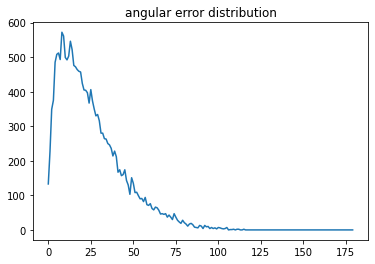

0.8615892174963133


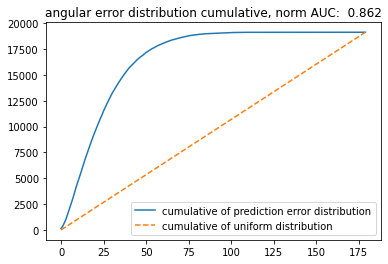

In [20]:
import matplotlib.pyplot as plt

plot_dir = os.path.join(save_path, "plots")
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

plt.title("angular error distribution")
values, bins = np.histogram(angular_errors, bins=180, range = [0, 180])
plt.plot(bins[:-1],values)
plt.savefig(os.path.join(plot_dir,"angular_error_distribution.jpg"), bbox_inches="tight", dpi=600)
plt.show()
plt.close()

# cumulative distribution
values, bins = np.histogram(angular_errors, bins=180, range = [0, 180])
cumul = np.cumsum(values)
tot_sum = np.sum(cumul) / (len(angular_errors) * 180.0)
print(tot_sum)

plt.title("angular error distribution cumulative, norm AUC: {:6.3f}".format(tot_sum))

plt.plot(bins[:-1], cumul, label="cumulative of prediction error distribution")
plt.plot(bins[:-1], np.linspace(0, len(angular_errors), num=len(bins[:-1])), '--', label="cumulative of uniform distribution")
plt.legend()

plt.savefig(os.path.join(plot_dir,"angular_error_distribution_cumulative.jpg"), bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [21]:
tot_error_under_45 = cumul[45] / len(angular_errors)

results_file = os.path.join(save_path, "plots", "results.csv")
with open(results_file, 'w') as f:
    f.write("\"sep=;\"\n")
    f.write("img_name;theta;phi\n")
    
    for img_name in predictions.keys():
        f.write(img_name + ";" + str(predictions[img_name][0]) + ";" + str(predictions[img_name][1]) + "\n")


In [22]:
angular_errors_file = os.path.join(save_path, "plots", "angular_errors.csv")
with open(angular_errors_file, 'w') as f:
    f.write("\"sep=;\"\n")
    f.write("degree_error;cumul\n")
    
    for i in range(len(cumul)):
        f.write(str(i) + ";" + str(cumul[i]) + "\n")

In [23]:
mean_err = np.mean(angular_errors)
std_err = np.std(angular_errors)

print("Angular errors - mean: {}, std dev: {}".format(mean_err, std_err))

Angular errors - mean: 25.413841977317684, std dev: 18.612152137746044
